# 375 Final Project - Noise in Price Movements, Stock Market Simulation

## Libraries

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import yfinance as yf

## Data Gathering

In [2]:
# download live price history data from yahoo finance

# pick stock tickers representing each 11 sectors in the index
tickers = ['AAPL', 'UNH', 'BRK-A', 'AMZN', 'UNP',
           'GOOGL', 'PG', 'XOM', 'NEE', 'LIN', 'PLD']

# download price data for each ticker
data = yf.download(tickers, start='2021-01-01',
                   end='2023-12-31')['Adj Close']

# download spy (etf) using the portfolio weights of the sp500 index
sp500 = yf.download('SPY', start='2021-01-01',
                    end='2023-12-31')['Adj Close']

data.head()


[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed


,AAPL,AMZN,BRK-A,GOOGL,LIN,NEE,PG,PLD,UNH,UNP,XOM
Date,,,,,,,,,,,
2021-01-04,127.164131,159.331497,343525.0,86.306503,247.778168,69.310257,127.934158,89.847687,335.248718,189.960159,36.362686
2021-01-05,128.736404,160.925507,341820.0,87.002502,251.665085,69.823860,128.751038,89.988022,330.740326,192.290131,38.115105
2021-01-06,124.402924,156.919006,346189.0,86.143997,259.927246,73.241760,130.106293,87.855026,344.620361,196.313736,39.087696
2021-01-07,128.647964,158.108002,350089.0,88.717003,259.180481,74.044876,128.890305,89.174110,350.145477,199.046005,39.394371
2021-01-08,129.758347,159.134995,352039.0,89.891502,258.874084,75.763145,128.834564,90.371582,348.572357,204.753891,39.832485


## Returns vs Correlation

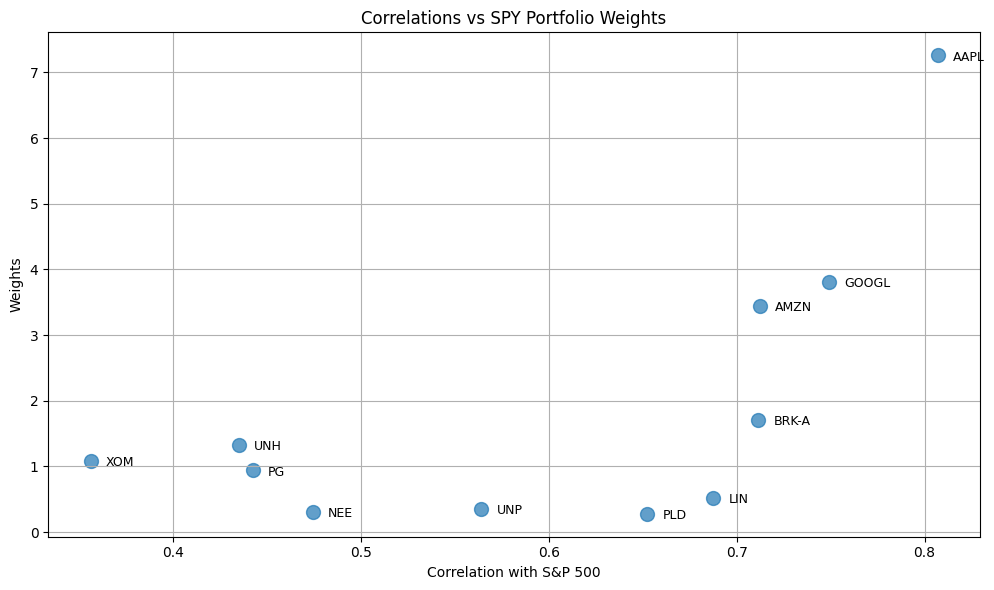

In [3]:
# calculate daily returns with pctchange
returns_sp500 = sp500.pct_change().dropna()
returns_stocks = data.pct_change().dropna()

# correlation of each ticker returns with sp500
correlation_with_sp500 = returns_stocks.corrwith(returns_sp500)

# current portfolio weights on sp500/spy for each ticker
weights = {'AAPL': 7.26, 'UNH': 1.33, 'BRK-A': 1.71, 'AMZN': 3.45, 'UNP': 0.36, 
           'GOOGL': 3.81, 'PG': 0.94, 'XOM': 1.08, 'NEE': 0.31, 'LIN': 0.52,
           'PLD': 0.28}

# use list comprehension to make lists of weights and correlations
# the indexes for each list, therefore the data will match according to each
#   ticker because of the order of the list
correlations = [correlation_with_sp500[ticker] for ticker in tickers]
stock_weights = [weights[ticker] for ticker in tickers]

# plot correlations vs their weight for each ticker
# expect more weight to have more correlation with the index
plt.figure(figsize=(10, 6))
plt.scatter(correlations, stock_weights, s=100, alpha=0.7)
plt.title('Correlations vs SPY Portfolio Weights')
plt.xlabel('Correlation with S&P 500')
plt.ylabel('Weights')
plt.grid(True)
plt.tight_layout()

# labels for each ticker on the plot, shift by small amounts for text to look
#   better
for i, ticker in enumerate(tickers):
    plt.text(correlations[i]+0.008, stock_weights[i]-0.08, ticker, fontsize=9)

plt.show()

## Denoising with Moving Averages

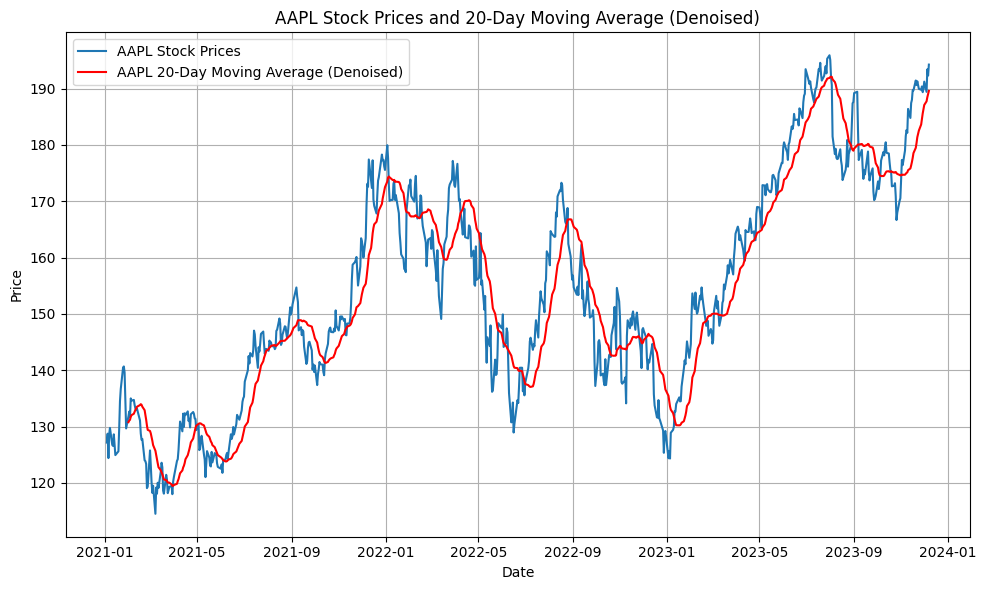

In [4]:
# look at how well denoising works for AAPL - Apple Inc.

# (denoising) moving average timeframe
windowsize = 20

# denoised sp500 and ticker data
moving_averages = data.rolling(window=windowsize).mean()
moving_avg_sp500 = sp500.rolling(window=windowsize).mean()

# moving average for AAPL - Apple Inc.
aapl_ma = data['AAPL'].rolling(window=windowsize).mean()

# plot original stock price and denoised moving average stock price
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['AAPL'], label='AAPL Stock Prices')
plt.plot(data.index, aapl_ma,
         label=f'AAPL {windowsize}-Day Moving Average (Denoised)',
         color='red')
plt.title(f'AAPL Stock Prices and {windowsize}-Day Moving Average (Denoised)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## Weighted Returns for Each Day

In [5]:
# add up all the weights for each ticker
total_weight = sum(weights.values())

normalized_weights = {}
total_weights = 0

# find normalized weight for each ticker based on total
for ticker, weight in weights.items():
  normalized_weights[ticker] = weight/total_weight

returns_data = returns_stocks.copy()

# dot product of returns and weights for each ticker to get weighted return
weighted_returns = returns_data.multiply(pd.Series(normalized_weights))

# sum by rows to get the weighted return for each day
# assign to new column called weighted
returns_data['Weighted'] = weighted_returns.sum(axis=1)

returns_data[['AAPL', 'AMZN', 'GOOGL', 'Weighted']].head()

,AAPL,AMZN,GOOGL,Weighted
Date,,,,
2021-01-05,0.012364,0.010004,0.008064,0.009596
2021-01-06,-0.033662,-0.024897,-0.009868,-0.010433
2021-01-07,0.034123,0.007577,0.029869,0.020858
2021-01-08,0.008631,0.006496,0.013239,0.008139
2021-01-11,-0.023249,-0.021519,-0.023106,-0.016296


## Noise Ratio

In [6]:
def noise_ratio(data, windowsize=20):
    '''
    This function calculates the noise ratio which depends on the rolling
      window of moving averages and the data being passed in. The data should
      be in a ticker in each column and row-temporal format.
    
    data: dataframe containing historical price data / days are rows and
      tickers are columns
    windowsize: 20 by default. parameter for moving average. how many days
      will be considered for the moving average (width of the window)
    '''
    # calculate the moving average using a rolling window
    ma = data.rolling(window=windowsize).mean()
    
    # calculate the noise as the difference between the data and moving average
    noise = data - ma
    
    # calculate the noise ratio by dividing the std of noise by the total std
    noiseratio = noise.std() / data.std()
    
    return noiseratio


In [7]:
# compute noise ratio for every ticker and print, format three decimals
for col in data.columns:
  ratio = noise_ratio(data[col])
  print(f'{col} Noise Ratio: {ratio:.3f}')

AAPL Noise Ratio: 0.323
AMZN Noise Ratio: 0.276
BRK-A Noise Ratio: 0.259
GOOGL Noise Ratio: 0.290
LIN Noise Ratio: 0.248
NEE Noise Ratio: 0.455
PG Noise Ratio: 0.370
PLD Noise Ratio: 0.371
UNH Noise Ratio: 0.241
UNP Noise Ratio: 0.459
XOM Noise Ratio: 0.150


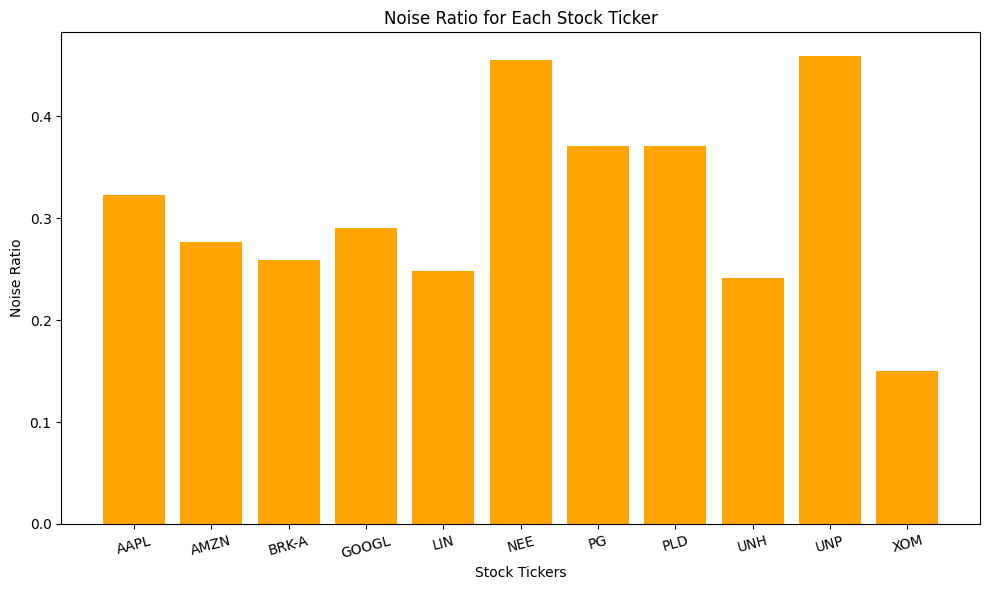

In [8]:
# align each noise ratio for each ticker by their original index
ratios = [noise_ratio(data[col]) for col in data.columns]

# barplot for noise of each ticker
plt.figure(figsize=(10, 6))
plt.bar(data.columns, ratios, color='orange')
plt.title('Noise Ratio for Each Stock Ticker')
plt.xlabel('Stock Tickers')
plt.ylabel('Noise Ratio')
plt.xticks(rotation=15)
plt.tight_layout()

plt.show()

## Simulation

### Random Walks Using Geometric Brownian Motion - GBM

/var/folders/lj/n6f9c71x3pnbtsr8rvdpw8w00000gn/T/ipykernel_20746/3614967282.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', nsimulations)


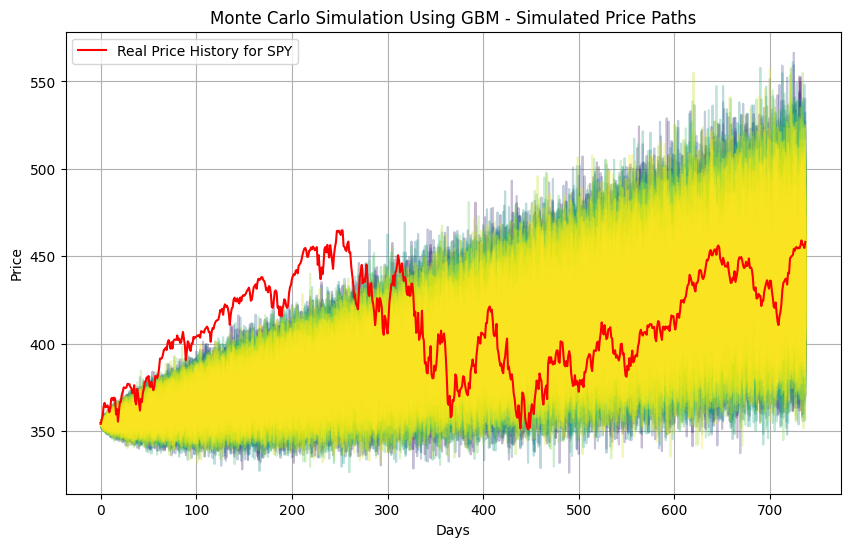

In [9]:
# initial price of the S&P 500 index (SPY) at the start of simulation
startprice = sp500.iloc[0]

# computing the logarithmic returns of the moving average of SPY
den500 = np.log(moving_avg_sp500 / moving_avg_sp500.shift(1))

# calculating the drift and volatility parameters for the GBM model
drift = den500.mean()  # drift based on the mean of logarithmic returns
volatility = den500.std()  # volatility based on the standard deviation 
                           # of logarithmic returns

# number of simulations and total number of days in the dataset
nsimulations = 2000
num_days = len(data)

# set seed for reproducibility
np.random.seed(123)

# initializing an array to store simulated price paths
simprices = np.zeros((nsimulations, num_days))

# assigning the initial SPY price to all simulations
simprices[:, 0] = startprice

# simulating price paths using GBM for each simulation
for i in range(nsimulations):
    for day in range(1, num_days):

        # calculate daily drift and volatility using GBM equation
        dailydr = (drift - 0.5 * volatility ** 2) * day
        dailyvo = volatility * np.sqrt(day) * np.random.normal()
        
        # update simulated prices based on the GBM formula
        simprices[i, day] = simprices[i, 0] * np.exp(dailydr + dailyvo)

# generating colors for each simulation to differentiate simulated paths
colormap = cm.get_cmap('viridis', nsimulations)

# plotting the simulated price paths along with the real price history of SPY
plt.figure(figsize=(10, 6))
for i in range(nsimulations):
    plt.plot(simprices[i], color=colormap(i), alpha=0.3)

plt.plot(sp500.values, color='red', alpha=1, label='Real Price History for SPY')
plt.title('Monte Carlo Simulation Using GBM - Simulated Price Paths')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# average standard deviation for each simulation
# axis = 1 means along each day/row
sim_stds = simprices.std(axis=1)
sim_stds.mean()

31.3497636366773

In [11]:
# standard deviation for the real data
sp500.std()

27.783611734175732

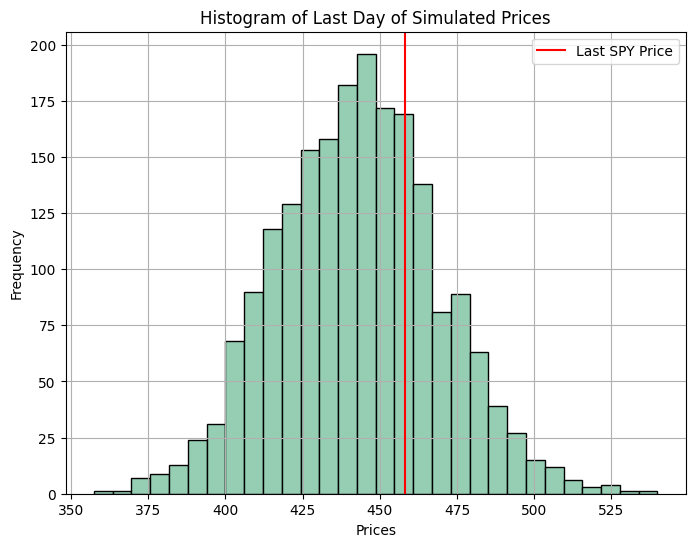

In [12]:
# extract last day's prices from simulation
last_simprices = simprices[:, -1]

# histogram for each simulation's last along with the real ending SPY price
plt.figure(figsize=(8, 6))
plt.hist(last_simprices, bins=30, color='#96ceb4',
         edgecolor='black')
plt.axvline(x=sp500.iloc[-1], color='r',
            linestyle='-', label='Last SPY Price')

plt.title('Histogram of Last Day of Simulated Prices')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# percentile of actual price according to the simulation
sum(last_simprices <= sp500.iloc[-1])/len(last_simprices)

0.7265